# **Image Classification**

In [17]:
from tensorflow.keras.datasets import cifar10


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"Train samples: {x_train.shape}")
print(f"Test samples: {x_test.shape}")

Train samples: (50000, 32, 32, 3)
Test samples: (10000, 32, 32, 3)


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

#Load CIFAR-10
from tensorflow.keras.datasets import cifar10

(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

print(f"Train samples: {x_train_full.shape}")
print(f"Test samples: {x_test.shape}")

#Normalize pixel values to [0, 1]
x_train_full = x_train_full / 255.0
x_test = x_test / 255.0

#Split train into training and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")

#Data Augmentation (no resizing now to avoid crash)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

#Create Data Generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32, shuffle=False)
test_generator = test_datagen.flow(x_test, y_test, batch_size=32, shuffle=False)

print("Data generators are ready without crashing RAM!")

Train samples: (50000, 32, 32, 3)
Test samples: (10000, 32, 32, 3)
Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Data generators are ready without crashing RAM!


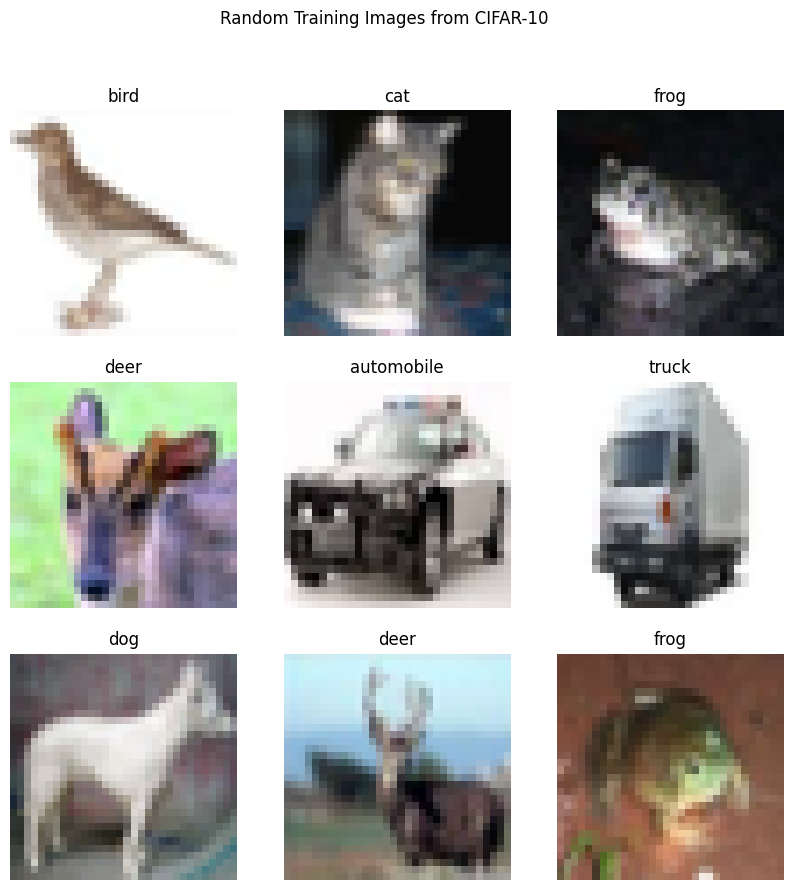

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


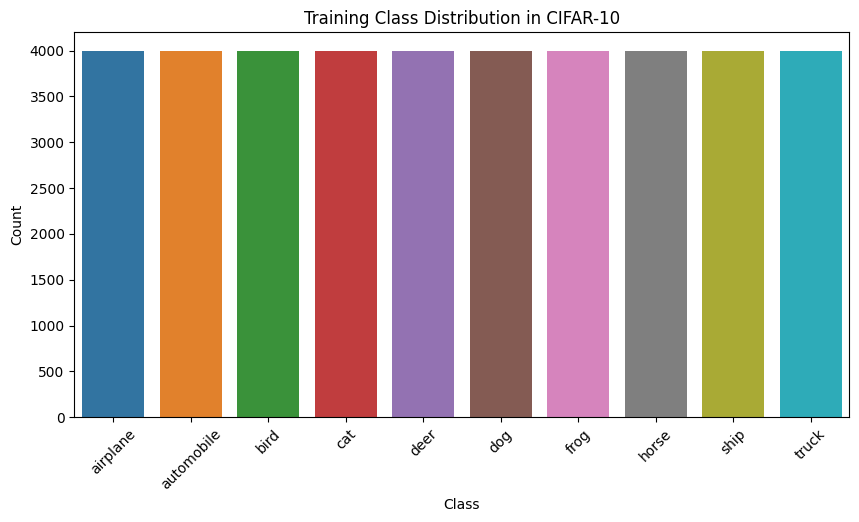

In [19]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Show 9 random training images
plt.figure(figsize=(10,10))
for i in range(9):
    idx = np.random.randint(0, x_train.shape[0])
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[idx])
    plt.title(class_names[y_train[idx][0]])
    plt.axis('off')
plt.suptitle("Random Training Images from CIFAR-10")
plt.show()

# Class distribution
import seaborn as sns
import pandas as pd

# Convert to Pandas Series
y_train_series = pd.Series(y_train.flatten())
class_counts = y_train_series.value_counts().sort_index()

plt.figure(figsize=(10,5))
sns.barplot(x=class_names, y=class_counts.values)
plt.title('Training Class Distribution in CIFAR-10')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Epoch 1/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3555 - loss: 2.2072
Epoch 1: val_loss improved from inf to 7.46248, saving model to best_resnet50_cifar10.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 47ms/step - accuracy: 0.3560 - loss: 2.2052 - val_accuracy: 0.1306 - val_loss: 7.4625 - learning_rate: 1.0000e-04
Epoch 2/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7285 - loss: 0.8408
Epoch 2: val_loss improved from 7.46248 to 0.98347, saving model to best_resnet50_cifar10.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.7285 - loss: 0.8407 - val_accuracy: 0.7660 - val_loss: 0.9835 - learning_rate: 1.0000e-04
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8208 - loss: 0.5686
Epoch 3: val_loss improved from 0.98347 to 0.90474, saving model to best_resnet50_cifar10.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8208 - loss: 0.5686 - val_accuracy: 0.7970 - val_loss: 0.9047 - learning_rate: 1.0000e-04
Epoch 4/50
625

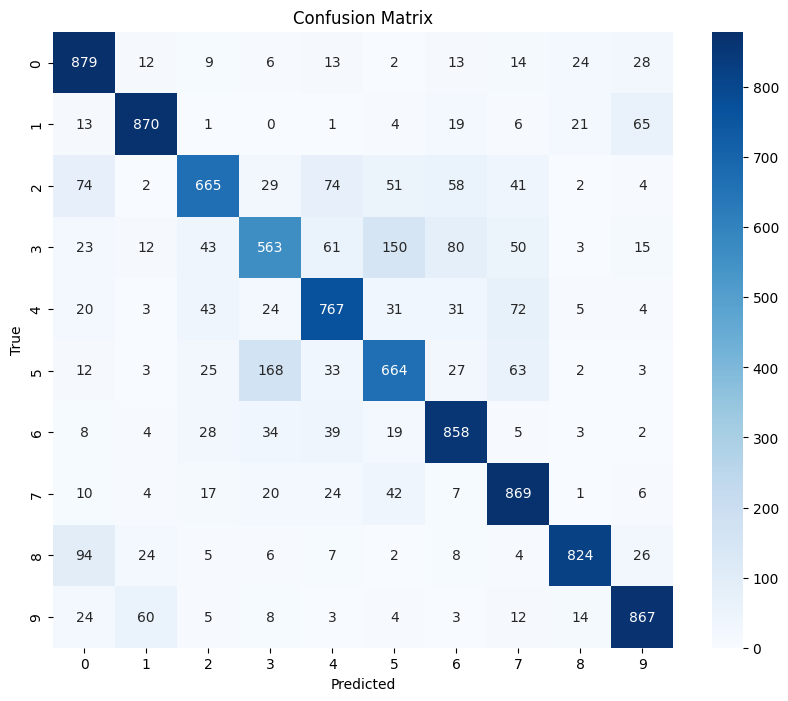

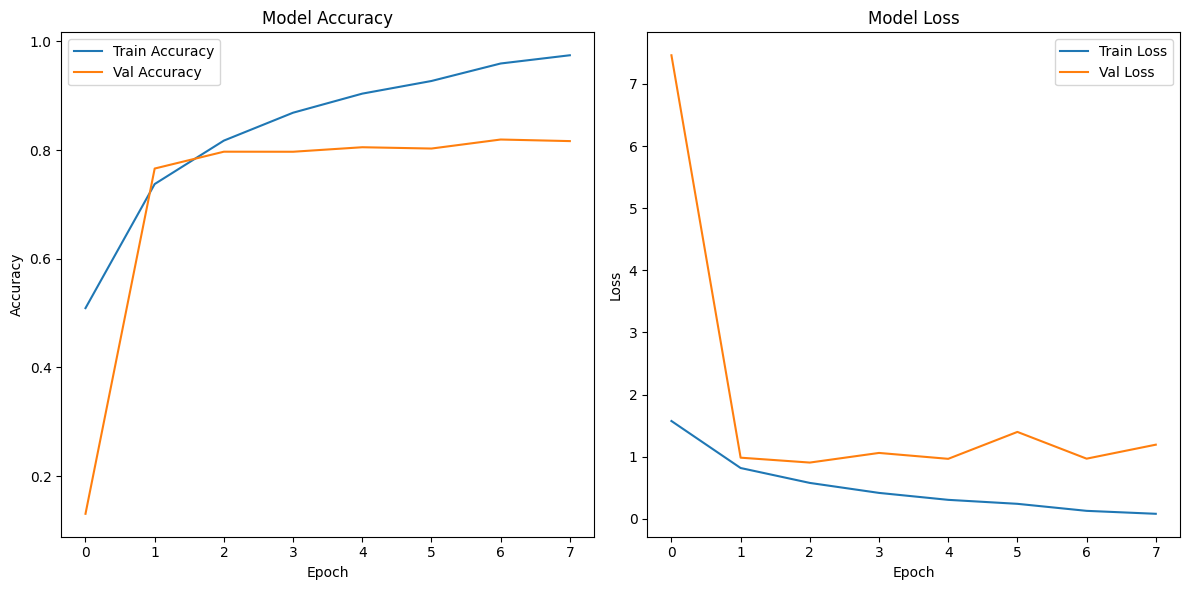

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Load and preprocess CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Load base model (ResNet50, pretrained on ImageNet)
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
resnet_base.trainable = False  # Freeze the base model

# Build the model
model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Initial compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Unfreeze the base model for fine-tuning
resnet_base.trainable = True

# Re-compile with RMSprop optimizer for fine-tuning
optimizer = RMSprop(learning_rate=1e-4, rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint(
    "best_resnet50_cifar10.keras",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Predict and evaluate
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Flatten y_test for proper evaluation
y_test_flat = y_test.flatten()

print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test_flat, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Training history
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the final model
model.save("resnet50_cifar10_finetuned_rmsprop.keras")


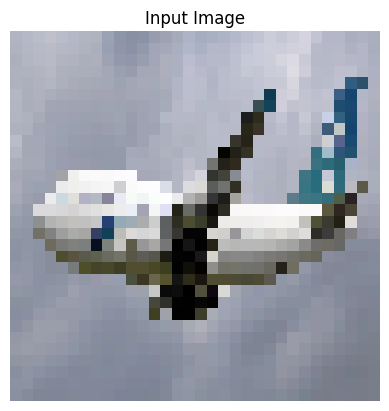

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (replace with the path to your image)
image_path = "/kaggle/input/test11/Air-New-Zealand-Boeing-747-400.webp"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize to CIFAR-10 dimensions (32x32x3)
img_resized = cv2.resize(img, (32, 32))

# Normalize the image
img_normalized = img_resized / 255.0

# Expand dimensions to match the model input (batch size of 1)
img_input = np.expand_dims(img_normalized, axis=0)

# Visualize the image
plt.imshow(img_resized)
plt.title("Input Image")
plt.axis('off')
plt.show()

In [22]:
# Make the prediction
pred_probs = model.predict(img_input)
predicted_class = np.argmax(pred_probs)

# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display the predicted class
print(f"Predicted Class: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: airplane
